# Compare with the experiments in (Khemakhem et al., 2021)
* For Figure 7

In [2]:
from util import *
from jax import grad, value_and_grad, jit,vmap, random
import sys

In [3]:
@jit
def loss_jax(params, df_batch,un):
    x,y = df_batch[:,0],df_batch[:,1]
    vec = jnp.sort(y) - jnp.sort(params*un)
    return jnp.var(vec)

val_and_grad = value_and_grad(loss_jax)
vmap_val_and_grad_inner = vmap(val_and_grad, in_axes=(None,None,1),out_axes=0)  
vmap_val_and_grad_outer = vmap(vmap_val_and_grad_inner, in_axes=(None,0,2),out_axes=0)  
vmap_val_and_grad_outer = jit(vmap_val_and_grad_outer)

In [4]:
def batch_test(df,resolution,npos):
    nghM = get_neighbor_matrix_fixed_num(df, resolution)
    batches = get_batches(data=df, neighborM=nghM, resolution=resolution, npos=npos)
    batches = jnp.array(batches)

    df_batch = batches[0]
    batch_sz,_ = df_batch.shape
    return batches,batch_sz

In [5]:
def test(batches,key_seed=42,step_sz = 1.0,exp = 200,nrep = 100):
    key = random.PRNGKey(key_seed)
    df_batch = batches[0]
    batch_sz,_ = df_batch.shape
    theta_H =0.2
    params = theta_H

    loss_res = []
    t_res = []
    gradt_res = []

    for j in range(exp):
        key, subkey = random.split(key)
        un = random.laplace(subkey,shape=(batch_sz,nrep,len(batches)))
        loss_val,grad = vmap_val_and_grad_outer(params, batches, un)
        ave_loss,ave_grad = np.mean(loss_val),np.mean(grad)
        params -= step_sz * ave_grad
        loss_res.append(ave_loss)
        t_res.append(params)
        gradt_res.append(ave_grad)
        if j%10==0:
            sys.stdout.write("\rDoing thing %i" % j)

    return loss_res,t_res,gradt_res,params

# Data generation
1. $Y = X + E_y$
2. $Y = X + 0.5 X^3+ E_y$

$E_y$ follows Laplace distribution.

In [6]:
nsamples = 100
resolution = 0.2
npos = 50

def f_t(x):
    return x
    # return x + 0.5*x**3

In [7]:
# Generate random ground truth W and b
key = random.PRNGKey(7)
k1, k2 = random.split(key)

# Generate samples with additional noise
ksample, knoise = random.split(k1)
x_samples = random.uniform(k1,shape=(nsamples, 1),minval=-1, maxval=1)

# y_samples = vmap(f_t)(x_samples)
y_samples = np.array([f_t(x) for x in x_samples])
# noise = random.uniform(k2,shape=(nsamples, 1),minval=0, maxval=1)
noise = random.laplace(k2,shape=(nsamples, 1))
y_samples += noise
x= x_samples.reshape(-1)
y= y_samples.reshape(-1)

## Preprocessing
We only keep the data within 2 standard deviation

In [8]:

x= normalize(x)
y= normalize(y)
x,y = x.reshape(-1),y.reshape(-1)

rangex = 2
rangey = 2
x = x[y<rangey]
y = y[y<rangey]
x = x[y>-rangey]
y = y[y>-rangey]
y = y[x<rangex]
x = x[x<rangex]
y = y[x>-rangex]
x = x[x>-rangex]

ind = np.arange(0,len(x),1)
key, subkey = random.split(key)
ind = random.permutation(key, ind)


x = x[ind]
y = y[ind]

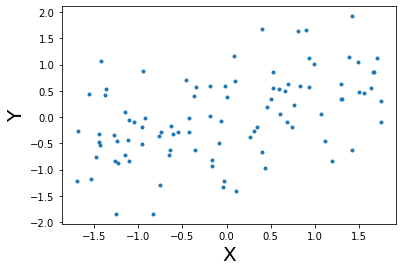

In [9]:
n = len(x)
plt.scatter(x,y,marker='.')
plt.xlabel('X',fontsize=20)
plt.ylabel('Y',fontsize=20)

df_c = np.zeros([n,2])
df_c[:,0],df_c[:,1] = x,y
df_sort_c = sortBycol(df_c,0)

df_rv = np.zeros([n,2])
df_rv[:,0],df_rv[:,1] = y,x
df_sort_rv = sortBycol(df_rv,0)

In [10]:
if n < 50:
    npos=n

In [14]:
c_batches,c_batch_sz = batch_test(df_sort_c,resolution,npos)
c_loss_res, c_t_res, c_gradt_res, params_c = test(c_batches, key_seed = 42, step_sz = 0.05, exp = 100,nrep = 50)
loss_c = np.mean(c_loss_res[-10:])/params_c**2

rv_batches,rv_batch_sz = batch_test(df_sort_rv,resolution,npos)
rv_loss_res,rv_t_res,rv_gradt_res,params_rv = test(rv_batches,key_seed = 42, step_sz = 0.05, exp = 100,nrep = 50)
loss_rv = np.mean(rv_loss_res[-10:])/params_rv**2

Doing thing 90

0.4638038


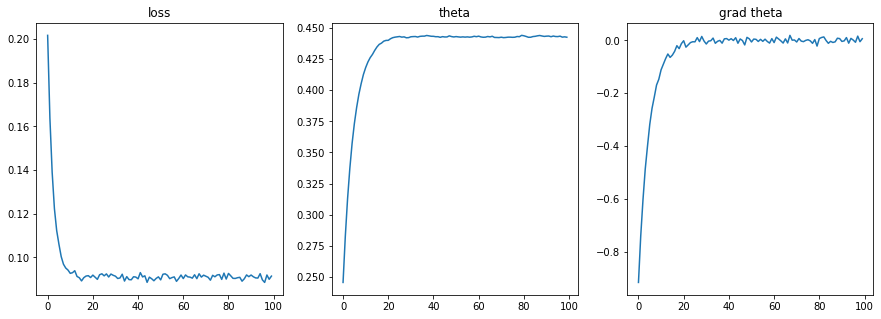

In [15]:
print(loss_c)
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('loss')
plt.plot(np.arange(0,len(c_loss_res),1), c_loss_res)

plt.subplot(1,3,2)
plt.title('theta')
plt.plot(np.arange(0,len(c_t_res),1), c_t_res)

plt.subplot(1,3,3)
plt.title('grad theta')
plt.plot(np.arange(0,len( c_gradt_res),1), c_gradt_res)

0.57305086


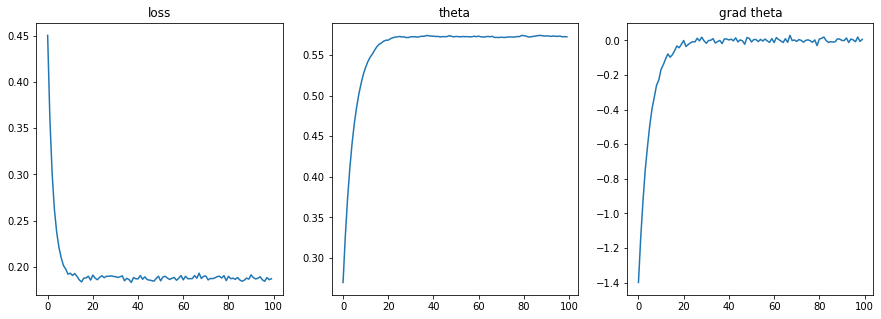

In [16]:
print(loss_rv)
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('loss')
plt.plot(np.arange(0,len(rv_loss_res),1), rv_loss_res)

plt.subplot(1,3,2)
plt.title('theta')
plt.plot(np.arange(0,len(rv_t_res),1), rv_t_res)

plt.subplot(1,3,3)
plt.title('grad theta')
plt.plot(np.arange(0,len( rv_gradt_res),1), rv_gradt_res)